In [2]:
# Assignment 6: Transfer Learning with ResNet18

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# =====================
# 1. Data Preparation
# =====================
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load CIFAR-10
trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
valset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_val)

# Use only a subset for faster training
subset_size = 5000
train_subset, _ = random_split(trainset, [subset_size, len(trainset) - subset_size])

trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# =====================
# 2. Load Pretrained Model (ResNet18)
# =====================
model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze convolutional base
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),   # 10 CIFAR-10 classes
    nn.LogSoftmax(dim=1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# =====================
# 3. Loss and Optimizer
# =====================
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)



In [3]:
# =====================
# 4. Training Loop
# =====================
train_loss_history, val_loss_history, val_acc_history = [], [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss/len(trainloader):.4f}, "
          f"Val Loss: {val_loss/len(valloader):.4f}, "
          f"Val Acc: {acc:.2f}%")

    train_loss_history.append(running_loss/len(trainloader))
    val_loss_history.append(val_loss/len(valloader))
    val_acc_history.append(acc)


Epoch 1/5, Train Loss: 1.6644, Val Loss: 1.3062, Val Acc: 56.20%
Epoch 2/5, Train Loss: 1.2622, Val Loss: 1.1985, Val Acc: 59.53%
Epoch 3/5, Train Loss: 1.1699, Val Loss: 1.1603, Val Acc: 60.33%
Epoch 4/5, Train Loss: 1.1463, Val Loss: 1.1541, Val Acc: 60.93%
Epoch 5/5, Train Loss: 1.0769, Val Loss: 1.1555, Val Acc: 60.87%


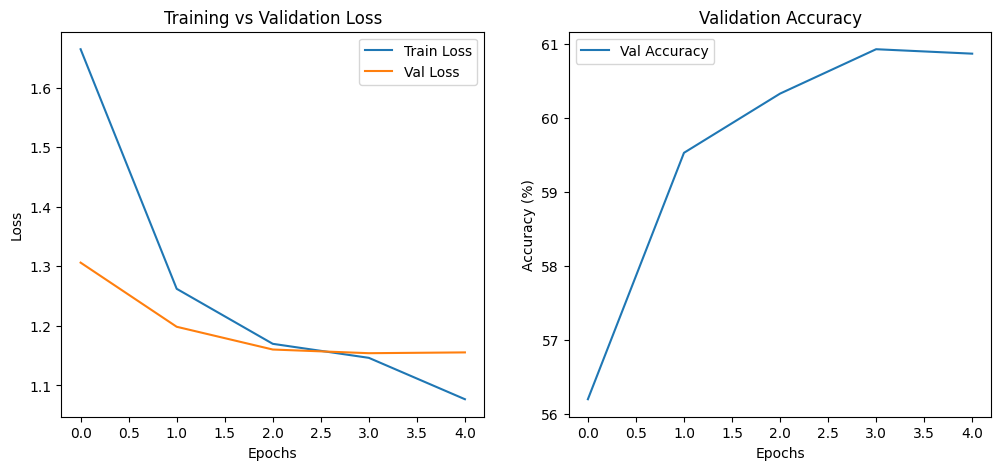

In [4]:

# =====================
# 5. Plot Loss & Accuracy
# =====================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.subplot(1,2,2)
plt.plot(val_acc_history, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation Accuracy")

plt.show()
